## Librerias requeridas

Configuración inicial para modo de ejecución

In [42]:
flag_runlocal = False    # "False" para ejecutar en google colab

Las librerías a continuación han sido desarrolladas para estre curso. Éstas se encargan del procesamiento del modelo, la implementación numérica de la solución y calculos de productos asociados (IRF, KF y proyección), ademas del manejo de los datos.

In [43]:
import sys
import os

if flag_runlocal:
    # ---> Ejecución local
    pathPolMon = os.getcwd() + '/'

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/jamayat/CUECOPolMon.git
    pathPolMon = '/content/CUECOPolMon/'

sys.path.append(pathPolMon+'02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

fatal: destination path 'CUECOPolMon' already exists and is not an empty directory.
IPython console for SymPy 1.13.1 (Python 3.11.11-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.1/



Librería externas complementarias

In [44]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# IRF
Horizon=20

## Procesamiento el modelo

In [46]:
Mod = DPP.process_file3(pathPolMon+'04_Modelo/MPTBolsillo.txt')

In [47]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

1. Se cargan los datos de variables observables. Estas se recaban de instituciones de estadísticas y se sintetizan para que sean insumidas por el modelo.

In [48]:
Describ, DBobs = HTS.ReadDB_excel(pathPolMon+'Tarea/DataTarea.xlsx', sheet='VarObs')

### Solución del modelo y estimaciones

A continuación se resuelve el modelo y se verifican las condiciones de estabilidad.
Es necesario incluir una calibración de coeficientes y un estado estacionario (**ver**: 04_Modelo/Cal_MPTBolsillo.txt)

**Nota**: En caso deseen hacer cambios en coeficientes, estos deben ocurrir en esta etapa

- Solución del modelo
- Estimación de IRF
- Filtro de Kalman

Se proyectarán 8 trimestres desde el último periodo de información 2024Q4.

La proyección es libre de condicionantes. En consecuencia, se observa la convergencia de la economía hacia su estado estacionario, tomando como punto de partida la situación inicial. Cabe destacar que ciertas variables presentan dependencia de múltiples rezagos.

In [49]:
FH = 8 # Horizonte de proyección (2 años)
StartingPeriod = '2025Q1'

In [50]:
UCond_base = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

Mod_base   = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsillo.txt", True)
IRF_base   = DLM.getIRF(Mod_base,Horizon)
DF_s_base, DF_u_base, minuslogL_base = DLM.KFts(DBobs, Mod_base, {'diffuse':False})
Data_base  = DF_s_base.copy()
UFDB_base = DLM.DSGEforecast0(Mod_base,Data_base,FH,StartingPeriod,UCond_base)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


In [51]:
tpmfija = True

if tpmfija:
    UCond_base['Uvar']['var']['i'] = pd.Series(
    np.append(UFDB_base.i.iloc[-(FH):].values[1:], UFDB_base.i.iloc[-1]),
    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
)
    UCond_base['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_base['UShock'] or UCond_base['UShock'][var_soft_tune].isna().all():
                UCond_base['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

UFDB_base = DLM.DSGEforecast0(Mod_base,Data_base,FH,StartingPeriod,UCond_base)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


In [52]:
UCond_sens = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    # Definir la nueva senda manualmente
    nueva_senda = np.array([3.91666, 3.9166, 3.75, 3.6666, 3.5, 3.5, 3.416, 3.25])

    # Asignar la nueva senda con el índice original de los últimos FH valores
    UCond_sens['Uvar']['var']['i'] = pd.Series(nueva_senda, index=UFDB_base.i.index[-FH:])

    # Agregar el shock correspondiente
    UCond_sens['Uvar']['shock'].append('res_i')


soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_sens['UShock'] or UCond_sens['UShock'][var_soft_tune].isna().all():
                UCond_sens['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

Mod_alt    = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsilloAlt.txt", False)
IRF_alt    = DLM.getIRF(Mod_alt,Horizon)
DF_s_alt, DF_u_alt, minuslogL_alt = DLM.KFts(DBobs, Mod_alt, {'diffuse':False})
Data_alt   = DF_s_alt.copy()
UFDB_alt  = DLM.DSGEforecast0(Mod_alt,Data_base,FH,'2025Q1',UCond_sens)

UCond_sensno = UCond_base

print(UCond_sensno)

UFDB_sensno = DLM.DSGEforecast0(Mod_alt,Data_base,FH,'2025Q1',UCond_sensno)

{'Uvar': {'var':                  DYs        ys      Dpae         t         g  DTI  Dps  \
2025-03-31  2.207918 -0.105134  2.987568 -0.298048 -0.126319  5.0  1.8   
2025-06-30  1.975786 -0.071549  1.998147 -0.116924 -0.050679  5.0  1.8   
2025-09-30  1.781167 -0.048265  2.000000 -0.045869 -0.020332  4.0  1.9   
2025-12-31  1.640418 -0.031798  2.000000 -0.017995 -0.008157  4.0  1.9   
2026-03-31  1.546577 -0.020405  2.000000 -0.007059 -0.003273  3.0  2.0   
2026-06-30  1.488975 -0.015011  2.000000 -0.002769 -0.001313  3.0  2.0   
2026-09-30  1.457705 -0.015015  2.000000 -0.001086 -0.000527  2.0  2.0   
2026-12-31  1.444628 -0.015854  2.000000 -0.000426 -0.000211  2.0  2.0   

                iext         i  
2025-03-31  0.600000  3.598635  
2025-06-30  0.800000  3.496318  
2025-09-30  0.900000  3.371692  
2025-12-31  1.100000  3.255360  
2026-03-31  1.200000  3.159327  
2026-06-30  1.200000  3.088785  
2026-09-30  1.300000  3.041262  
2026-12-31  1.423304  3.041262  , 'shock': ['res_DYs

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')
/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


In [53]:
BDdictsens = {'Base': UFDB_base, 'Sensibilidad: Inacción': UFDB_sensno, 'Sensibilidad: Programa': UFDB_alt}

### **Canal de expectativas**
Dado el reciente periodo de alta inflación,

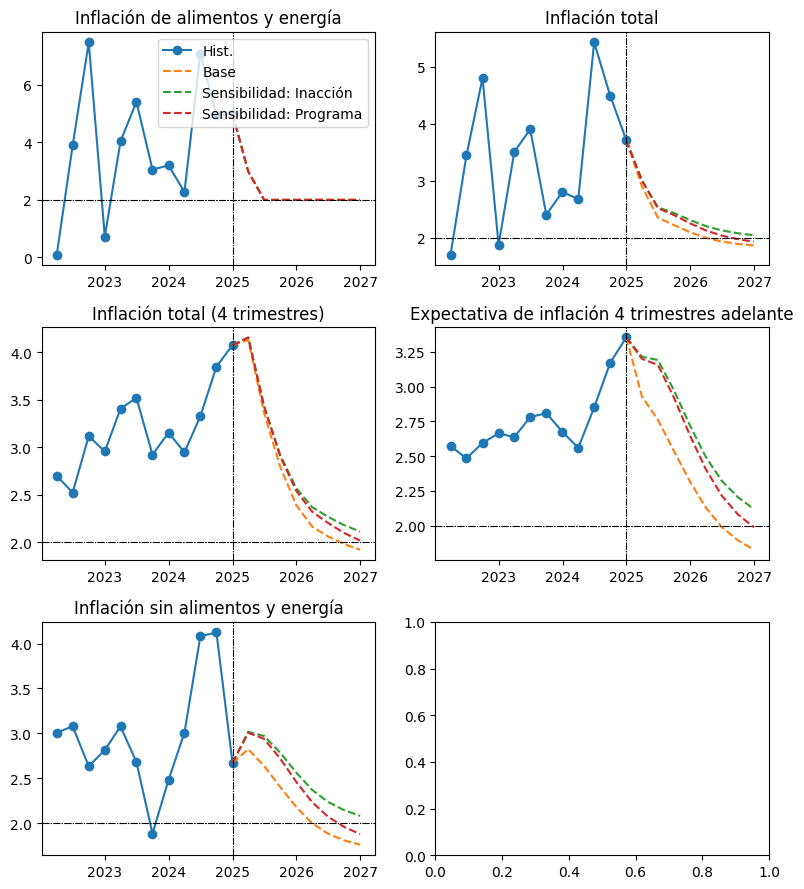

In [54]:

lista = ['Dpae', 'Dp', 'D4p', 'ED4p', 'Dpsae']

listanames = [
    'Inflación de alimentos y energía',
    'Inflación total',
    'Inflación total (4 trimestres)',
    'Expectativa de inflación 4 trimestres adelante',
    'Inflación sin alimentos y energía'
]

listaSS = [2.00, 2.00, 2.00, 2.00, 2.00]
HH = 12
fig, axs = HTS.plotTSforecast(BDdictsens,lista,listanames,listaSS,FH,HH,3,2)

### **Canal de tipo de cambio**

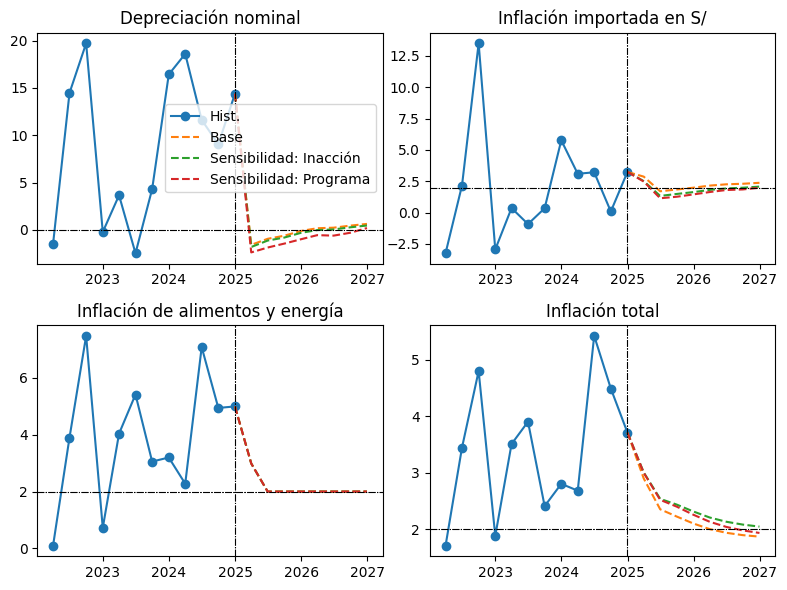

In [55]:
#Empezamos por el aumento del riesgo pais
lista = ['Ds', 'Dpm', 'Dpae', 'Dp']

listanames = [
    'Depreciación nominal',
    'Inflación importada en S/',
    'Inflación de alimentos y energía',
    'Inflación total'
]

listaSS = [0.00, 2.00, 2.00, 2.00]

# Configuración del gráfico
HH = 12  # Horizonte de pronóstico

# Crear el gráfico
fig, axs = HTS.plotTSforecast(BDdictsens,lista,listanames,listaSS,FH,HH,2,2)

### **Canal de tasas de interés**

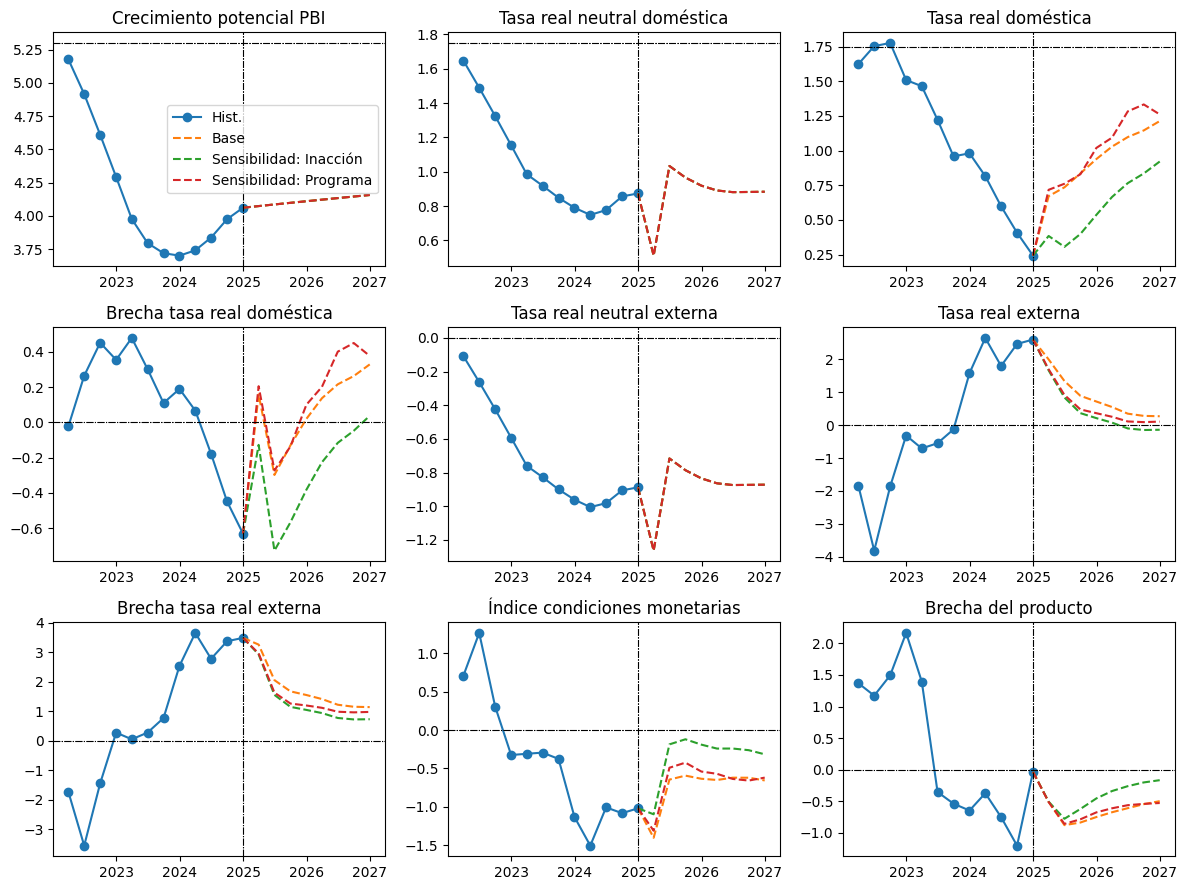

In [56]:
# Variables organizadas por categoría
variables = ['DY_eq', 'Rmn_eq', 'Rmn', 'rmn', 'Rme_eq', 'Rme', 'rme', 'rmc', 'y']

# Nombres descriptivos
nombres = [
    'Crecimiento potencial PBI',
    'Tasa real neutral doméstica',
    'Tasa real doméstica',
    'Brecha tasa real doméstica',
    'Tasa real neutral externa',
    'Tasa real externa',
    'Brecha tasa real externa',
    'Índice condiciones monetarias',
    'Brecha del producto'
]

# Valores de estado estacionario
ss_values = [
    5.30,   # DY_eq (potential growth)
    1.75,   # Rmn_eq (neutral rate)
    1.75,   # Rmn (equals neutral in SS)
    0.00,   # rmn (gap is zero in SS)
    0.00,   # Rme_eq (external neutral rate)
    0.00,   # Rme (equals external neutral)
    0.00,   # rme (gap is zero in SS)
    0.00,   # rmc (monetary conditions index)
    0.00    # y (output gap)
]

# Configuración del gráfico (4x3 para 12 variables)
fig, axs = HTS.plotTSforecast(
    BDdictsens,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,
    3
)

### **Reporte de variables relevantes**

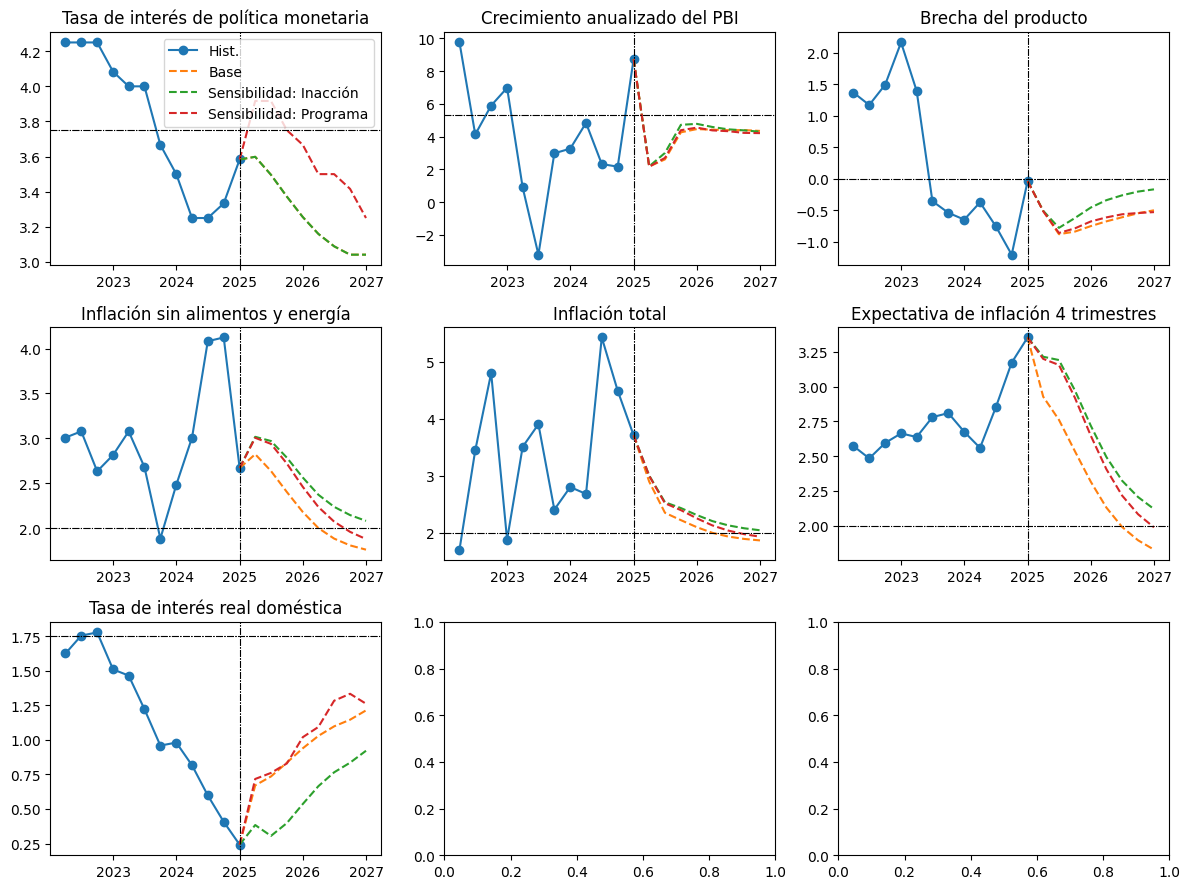

In [57]:
# Variables to plot - Monetary policy and inflation focus
variables = ['i', 'DY', 'y', 'Dpsae', 'Dp', 'ED4p', 'Rmn']

# Descriptive names
nombres = [
    'Tasa de interés de política monetaria',
    'Crecimiento anualizado del PBI',
    'Brecha del producto',
    'Inflación sin alimentos y energía',
    'Inflación total',
    'Expectativa de inflación 4 trimestres',
    'Tasa de interés real doméstica'
]

# Steady-state values
ss_values = [
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    5.30,   # DY (DY_ss)
    0.00,   # y
    2.00,   # Dpsae (Dp_ss)
    2.00,   # Dp (Dp_ss)
    2.00,   # ED4p (Dp_ss)
    1.75    # Rmn (Rmn_ss)
]

# Plot configuration (3x3 grid with 2 empty spots)
fig, axs = HTS.plotTSforecast(
    BDdictsens,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,  # 3 rows
    3   # 3 columns
)

### Brecha producto

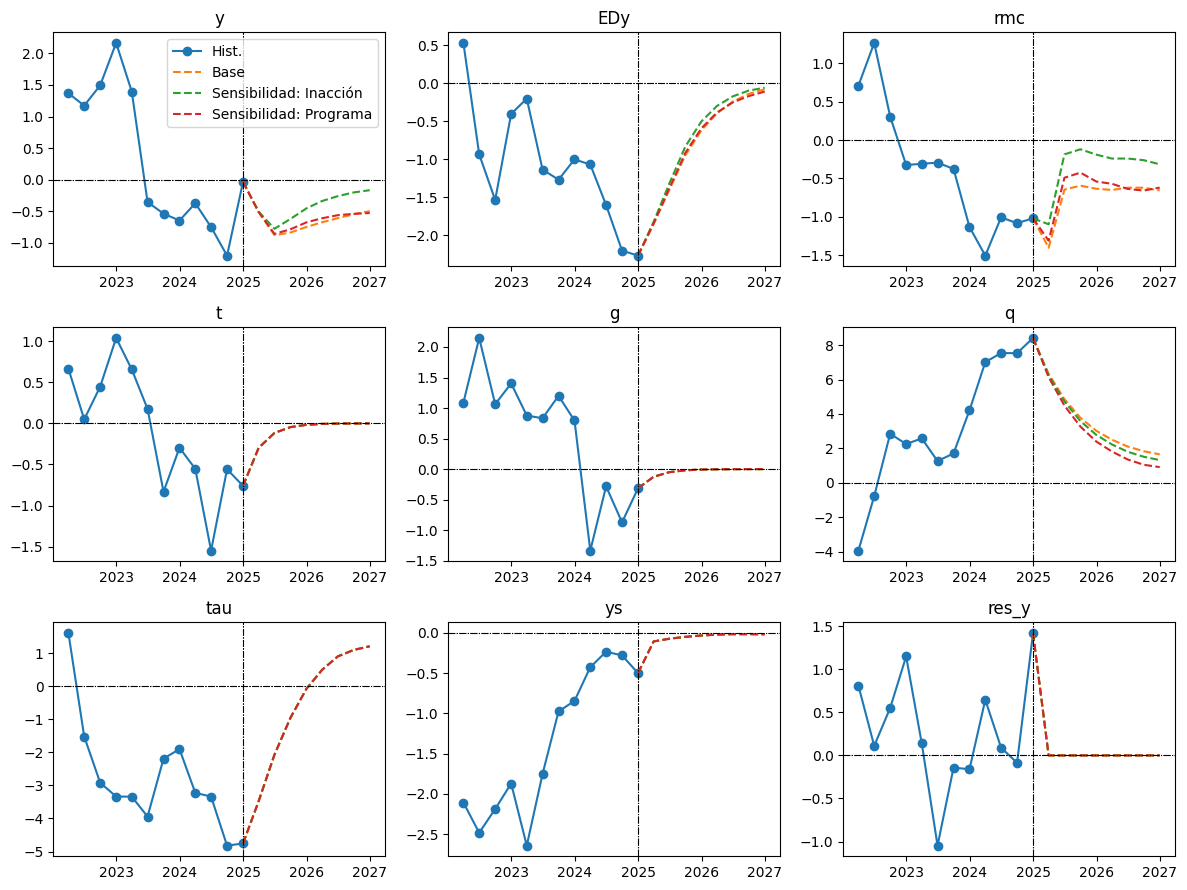

In [58]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdictsens,lista,listanames,listaSS,FH,HH,3,3)

### Cuadros de Impacto

In [59]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_alt['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_alt['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_alt['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_alt['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_alt['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_alt['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_alt['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_alt['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_alt['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_alt['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_alt.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
Brecha: y,-0.372058,-0.749937,-1.201698,-0.034537,-0.511692,-0.857671,-0.784693,-0.675066,-0.610588,-0.561227,-0.540760,-0.526739
Inercia: (ay+aEy)*y(-1),-0.430945,-0.248237,-0.500358,-0.801773,-0.023043,-0.341401,-0.572238,-0.523547,-0.450404,-0.407384,-0.374451,-0.360795
Confianza: aEy*EDy,-0.136213,-0.204320,-0.280940,-0.289453,-0.235419,-0.175735,-0.116554,-0.075423,-0.048803,-0.031763,-0.021257,-0.013666
Cond. Mon.: armc*rmc(-1),-0.339501,-0.451219,-0.301934,-0.324542,-0.305547,-0.392896,-0.147259,-0.127333,-0.162084,-0.170924,-0.190938,-0.197233
Imp. Rec.: -at*t,0.002764,0.007736,0.002787,0.003799,0.001490,0.000585,0.000229,0.000090,0.000035,0.000014,0.000005,0.000002
Imp. gasto: ag*g,-0.153978,-0.032631,-0.100608,-0.036271,-0.014552,-0.005838,-0.002342,-0.000940,-0.000377,-0.000151,-0.000061,-0.000024
TCRM: aq*q,0.162716,0.174880,0.174753,0.195245,0.142481,0.104124,0.075828,0.055579,0.042162,0.031406,0.024358,0.021168
Imp. TI: atau*tau,-0.066133,-0.068470,-0.098857,-0.097495,-0.071309,-0.042567,-0.019698,-0.001740,0.010007,0.018403,0.022409,0.024684
Socios: ays*ys,-0.023415,-0.012813,-0.015377,-0.027463,-0.005793,-0.003942,-0.002659,-0.001752,-0.001124,-0.000827,-0.000827,-0.000874
Res.: m_res_y*res_y,0.617019,0.091092,-0.075775,1.348582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_alt['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_alt['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_alt['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_alt['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_alt['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_alt['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_alt['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_alt.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
Inflación trimestral SAE anualizada: Dpsae,3.008166,4.082850,4.124964,2.669623,3.005656,2.938284,2.718370,2.458585,2.234405,2.071048,1.957113,1.876930
Inflación importada a 4 trimestres: bm*D4pm,0.137678,0.206255,0.202014,0.160133,0.149865,0.115458,0.134987,0.105236,0.091361,0.102273,0.111918,0.120753
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1),0.586868,0.711374,0.965516,0.975475,0.631315,0.710780,0.694848,0.642843,0.581408,0.528394,0.489763,0.462820
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p,1.784431,1.986789,2.211417,2.337770,2.230410,2.199954,2.035883,1.845317,1.677611,1.545280,1.451850,1.386260
Brecha producto: by*cy*y,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Inercia de brecha producto: by*(1-cy)*y(-1),-0.110966,-0.063920,-0.128839,-0.206452,-0.005933,-0.087909,-0.147348,-0.134810,-0.115976,-0.104899,-0.096419,-0.092903
Residuo: m_res_Dsae*res_Dpsae,0.587748,1.208491,0.832092,-0.640683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_alt['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_alt['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_alt['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_alt['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_alt['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_alt['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_alt['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_alt['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_alt['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_alt.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
TPM: i,3.250000,3.250000,3.333333,3.583333,3.916660,3.916600,3.750000,3.666600,3.500000,3.500000,3.416000,3.250000
Crecimiento PBI real: DY,4.836882,2.325826,2.168388,8.730329,2.165446,2.702408,4.390373,4.548988,4.380284,4.331592,4.227675,4.213433
Brecha producto: y,-0.372058,-0.749937,-1.201698,-0.034537,-0.511692,-0.857671,-0.784693,-0.675066,-0.610588,-0.561227,-0.540760,-0.526739
Inflación SAE: Dpsae,3.008166,4.082850,4.124964,2.669623,3.005656,2.938284,2.718370,2.458585,2.234405,2.071048,1.957113,1.876930
Inflación total: Dp,2.680545,5.422641,4.489321,3.708887,2.997566,2.517798,2.397072,2.253478,2.129565,2.039271,1.976295,1.931974
Expectativa de inflación: ED4p,2.559722,2.850000,3.172222,3.353472,3.199467,3.155780,2.920424,2.647061,2.406492,2.216666,2.082643,1.988555
Tasa real en moneda nacional: Rmn,0.815978,0.598333,0.407378,0.241861,0.717193,0.760820,0.829576,1.019539,1.093508,1.283334,1.333357,1.261445
Depreciación nominal: Ds,18.601325,11.631337,9.053224,14.390420,-2.371190,-1.855262,-1.439226,-0.981313,-0.547672,-0.596695,-0.293592,0.203185
Inflación AE: Dpae,2.275660,7.078403,4.939607,4.993248,2.987568,1.998147,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
